### IM02 Online Section Group Notebook

#### Business Objective
Which team would be the best to invest in for the upcoming season?


#### Analytical Questions
Q1: Which teams have most consistently had the highest scores?

Q2: Which team has had below average for the most consecutive seasons?

Q3: Which team has consistently made it to the playoffs?

Q4: Which teams have shown the greatest improvement over the past five years?

Q5. Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?

#### Q1: Which teams have most consistently had the highest scores?

In [43]:
import pandas as pd
import sqlite3


#using entire database
con = sqlite3.connect("data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)
active_players = pd.read_sql_query("SELECT full_name FROM player WHERE is_active=TRUE", con)


# games data excluding all-star games (2019-2023)

games_recent_5yrs = pd.read_sql_query("""
	SELECT * FROM game 
	WHERE season_type NOT IN ('All Star', 'All-Star') 
	AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

print(games_recent_5yrs.head(5))

  season_id team_id_home team_abbreviation_home  team_name_home     game_id  \
0     42022   1610612743                    DEN  Denver Nuggets  0042200405   
1     42022   1610612748                    MIA      Miami Heat  0042200404   
2     42022   1610612748                    MIA      Miami Heat  0042200403   
3     42022   1610612743                    DEN  Denver Nuggets  0042200402   
4     42022   1610612743                    DEN  Denver Nuggets  0042200401   

             game_date matchup_home wl_home  min  fgm_home  ...  reb_away  \
0  2023-06-12 00:00:00  DEN vs. MIA       W  240      38.0  ...      44.0   
1  2023-06-09 00:00:00  MIA vs. DEN       L  240      35.0  ...      34.0   
2  2023-06-07 00:00:00  MIA vs. DEN       L  240      34.0  ...      58.0   
3  2023-06-04 00:00:00  DEN vs. MIA       L  240      39.0  ...      31.0   
4  2023-06-01 00:00:00  DEN vs. MIA       W  240      40.0  ...      43.0   

   ast_away  stl_away  blk_away  tov_away  pf_away  pts_away  

In [111]:
# mean, standard deviation of scores for each team
score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name']
score_stats_away.index.names = ['team_id', 'team_name']

combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name']).mean()
score_stats_all['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats_all = score_stats_all[score_stats_all['total_games'] >= 100]

# teams with highest average
print("Teams with highest average scores:")
print(score_stats_all.sort_values(by='mean', ascending=False).head(20))

Teams with highest average scores:
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612749 Milwaukee Bucks         116.435716  12.726194  217.0          434
1610612762 Utah Jazz               114.124126  11.353901  196.5          393
1610612737 Atlanta Hawks           114.082051  12.425118  195.0          390
1610612750 Minnesota Timberwolves  114.046378  11.995903  184.0          368
1610612758 Sacramento Kings        113.760321  12.404773  186.5          373
1610612744 Golden State Warriors   113.553368  12.502250  207.5          415
1610612751 Brooklyn Nets           113.466575  12.269783  195.5          391
1610612740 New Orleans Pelicans    113.429579  11.357125  184.5          369
1610612763 Memphis Grizzlies       113.219401  12.564816  196.5          393
1610612756 Phoenix Suns            113.174049  11.591735  205.5          411
1610612743 Denver Nuggets          112.98

In [112]:
# teams with consistent scoring
print("Most consistent scoring teams (lowest standard deviation):")
print(score_stats_all.sort_values(by='std').head(20))

Most consistent scoring teams (lowest standard deviation):
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612762 Utah Jazz               114.124126  11.353901  196.5          393
1610612739 Cleveland Cavaliers     107.244895  11.354891  182.0          364
1610612740 New Orleans Pelicans    113.429579  11.357125  184.5          369
1610612756 Phoenix Suns            113.174049  11.591735  205.5          411
1610612748 Miami Heat              108.997146  11.596273  217.5          435
1610612761 Toronto Raptors         111.561036  11.654833  203.0          406
1610612743 Denver Nuggets          112.986301  11.774490  219.0          438
1610612753 Orlando Magic           107.049138  11.822853  189.0          378
1610612750 Minnesota Timberwolves  114.046378  11.995903  184.0          368
1610612765 Detroit Pistons         106.855801  11.997323  183.0          366
1610612747 Los An

#### Introduction

A "good" game isn't just about who wins. However, when it comes to which team to bet our money on, their points certainly matter. In evaluating teams for investment potential, scoring ability has traditionally been a key metric. With NBA scoring increasing in recent seasons, investors need to look deeper than just offensive output. Is a high-scoring offense truly indicative of a team's value and future success? To identify the most promising investment opportunities for the upcoming season, we analyzed scoring patterns from 2019-2023, examining not just point totals but offensive consistency. This comprehensive analysis aims to uncover teams that demonstrate sustainable excellence.

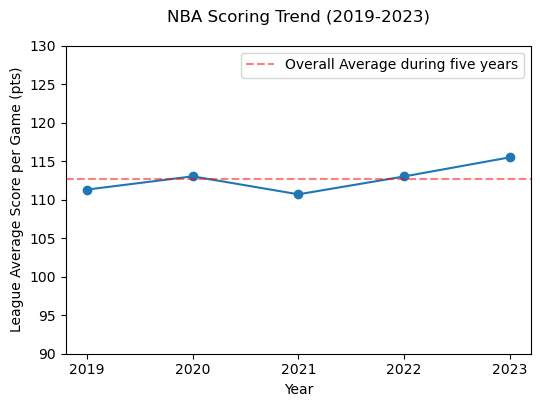

In [47]:
# visualization for introduction - League average trend 

import seaborn as sns
import matplotlib.pyplot as plt

regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

plt.figure(figsize=(6,4))
yearly_avg = regular_games.groupby('game_year').agg({
    'pts_home' : 'mean', 'pts_away' : 'mean'}).reset_index()
yearly_avg['points'] = (yearly_avg['pts_home'] + yearly_avg['pts_away'])/2
yearly_avg['game_year'] = yearly_avg['game_year'].astype(int)

plt.plot(yearly_avg['game_year'], yearly_avg['points'], marker='o')
plt.axhline(y=yearly_avg['points'].mean(), color='r', linestyle='--', alpha=0.5, label='Overall Average during five years')
plt.xticks(yearly_avg['game_year'])
plt.ylim(90,130)
plt.title('NBA Scoring Trend (2019-2023)', y=1.05)
plt.xlabel('Year')
plt.ylabel('League Average Score per Game (pts)')

plt.legend()
plt.show()

#### Rising Action

Initial market analysis might attract investors to the Milwaukee Bucks, who lead with an average of 116.44 points per game. However, high performance must be sustainable to ensure reliable returns. Our analysis shows that the top 10 teams all average over 113 points, indicating intense competition and multiple investment opportunities. The key question now is “Which team's offensive success is most sustainable?"

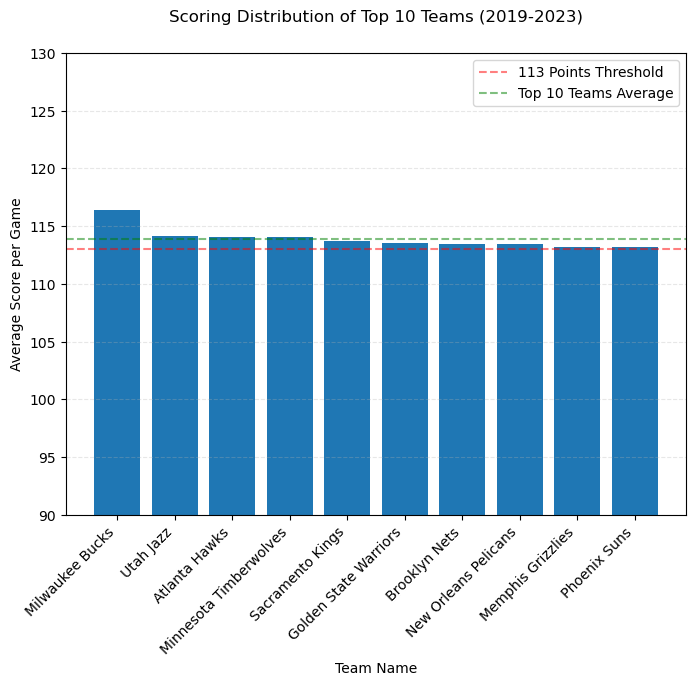

In [114]:
# visualization for Rising action - Top 10 teams scoring

top10_teams_scoring = score_stats_all.reset_index().sort_values(by='mean', ascending=False).head(10)
plt.figure(figsize=(8,6))
plt.bar(top10_teams_scoring['team_name'], top10_teams_scoring['mean'])
plt.xticks(rotation=45, ha='right')
plt.title('Scoring Distribution of Top 10 Teams (2019-2023)', y=1.05)
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.ylim(90, 130)

# 113 points & average line
plt.axhline(y=113, color='r', linestyle='--', alpha=0.5, label='113 Points Threshold')
top10_avg = top10_teams_scoring['mean'].mean()
plt.axhline(y=top10_avg, color='g', linestyle='--', alpha=0.5, label='Top 10 Teams Average')

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

#### Climax

The most meaningful insight came when we examined scoring consistency. While the Milwaukee Bucks led in scoring power, the Utah Jazz stood out in offensive efficiency, maintaining a high scoring average (114.12 points) with the league's lowest standard deviation (11.35). This remarkable consistency, coupled with their scoring volume, suggests an optimal balance of return and risk.

Additionally, teams like the New Orleans Pelicans, Phoenix Suns, and Denver Nuggets demonstrated exceptional consistency across over 400 games, despite not leading in raw scoring numbers. This highlights that offensive stability might be just as valuable as scoring power.

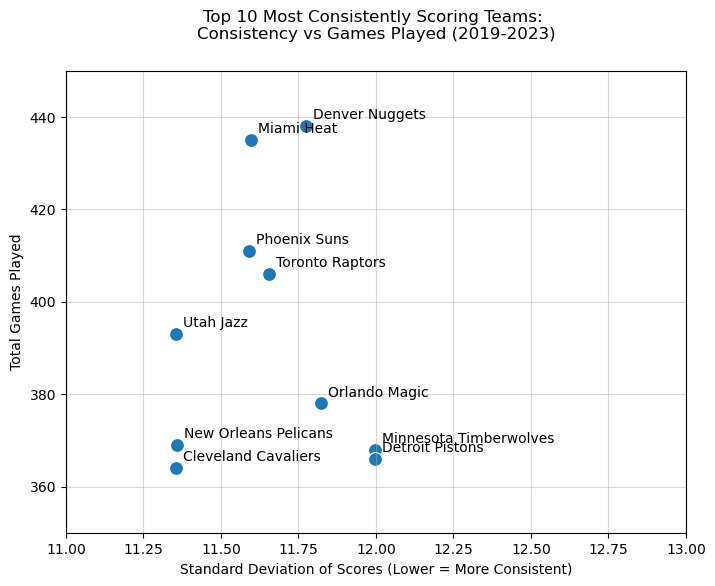

In [49]:
# visualization for Climax - Top 10 teams consistency

top10_teams_consistent = score_stats_all.reset_index().sort_values(by='std', ascending=True).head(10)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=top10_teams_consistent, 
                x='std', y='total_games', s=100)
# team name label 
for i in range(len(top10_teams_consistent)):
    plt.annotate(top10_teams_consistent['team_name'].iloc[i], 
                (top10_teams_consistent['std'].iloc[i], 
                 top10_teams_consistent['total_games'].iloc[i]),
                xytext=(5, 5), textcoords='offset points')
plt.xlim(11,13)
plt.ylim(350,450)
plt.title('Top 10 Most Consistently Scoring Teams: \nConsistency vs Games Played (2019-2023)', y=1.05)
plt.xlabel('Standard Deviation of Scores (Lower = More Consistent)')
plt.ylabel('Total Games Played')

plt.grid(True, alpha=0.5)
plt.show()

#### Falling Action

This discovery showed us that being the best isn't just about scoring the most points. It's about being able to perform well game after game. While teams with higher scoring averages might attract immediate attention, the Utah Jazz's combination of strong scoring and consistency supports long-term value appreciation. 

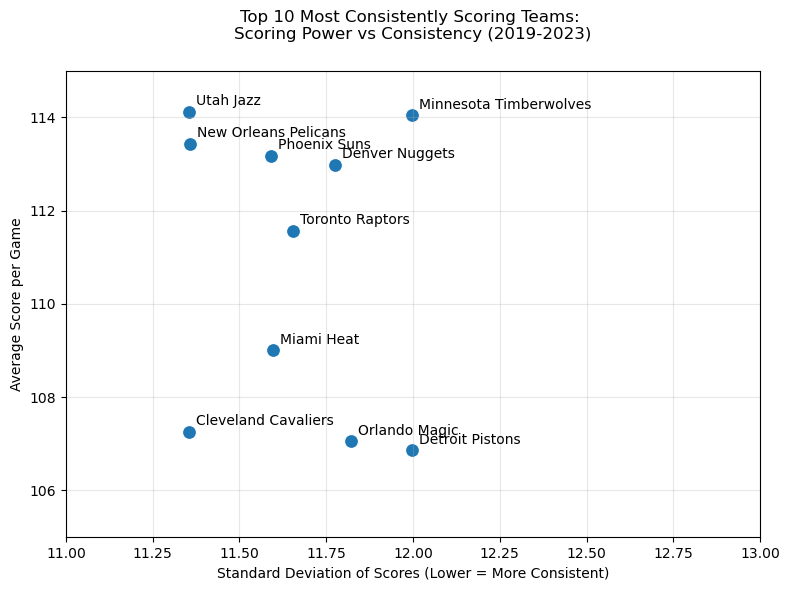

In [50]:
# visualization for Falling action - Top 10 teams consistency / scoring power

plt.figure(figsize=(8, 6))
sns.scatterplot(data=top10_teams_consistent, 
                x='std', y='mean', s=100)

# team name labels
for i in range(len(top10_teams_consistent)):
    plt.annotate(top10_teams_consistent['team_name'].iloc[i], 
                (top10_teams_consistent['std'].iloc[i], 
                 top10_teams_consistent['mean'].iloc[i]),
                xytext=(5, 5), textcoords='offset points')
plt.xlim(11,13)
plt.ylim(105,115)
plt.title('Top 10 Most Consistently Scoring Teams: \nScoring Power vs Consistency (2019-2023)', y=1.05)
plt.xlabel('Standard Deviation of Scores (Lower = More Consistent)')
plt.ylabel('Average Score per Game')
plt.grid(True, alpha=0.3)
plt.tight_layout()


#### Resolution

Our analysis suggests three investment opportunities – chosen due to their average points being over 114 per game, with a standard deviation under 12.:

1. Premium Investment (Utah Jazz): Balance of high scoring and consistency, suggesting strong fundamentals and reliable returns
2. Value Opportunities (New Orleans Pelicans, Phoenix Suns, Denver Nuggets): Strong consistency metrics suggest possible market undervaluation
3. Growth Potential (Minnesota Timberwolves): Higher scoring but more variable The Utah Jazz’s combination of offensive excellence and consistency makes them a particularly attractive investment option.

/var/folders/b2/t2bk4jsj6dz6nftdjx4m23w00000gn/T/ipykernel_5150/1328655458.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(resolution_data['team_name'], ha='right')
/var/folders/b2/t2bk4jsj6dz6nftdjx4m23w00000gn/T/ipykernel_5150/1328655458.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(resolution_data['team_name'], ha='right')


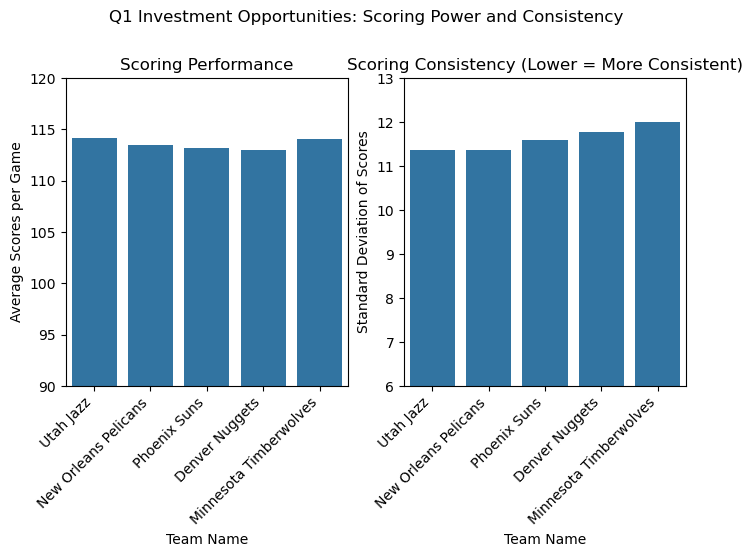

In [52]:
# visualization for resolution

teams_of_interest_q1 = ['Utah Jazz', 'New Orleans Pelicans', 'Phoenix Suns', 
                    'Denver Nuggets', 'Minnesota Timberwolves']
resolution_data = top10_teams_consistent[top10_teams_consistent['team_name'].isin(teams_of_interest_q1)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# teams of interest - average scores 
sns.barplot(data=resolution_data, x='team_name', y='mean', ax=ax1)
ax1.set_title('Scoring Performance')
ax1.set_xlabel('Team Name')
ax1.set_ylabel('Average Scores per Game')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticklabels(resolution_data['team_name'], ha='right')
ax1.set_ylim(90, 120)
# teams of interest - sd of scores
sns.barplot(data=resolution_data, x='team_name', y='std', ax=ax2)
ax2.set_title('Scoring Consistency (Lower = More Consistent)')
ax2.set_xlabel('Team Name')
ax2.set_ylabel('Standard Deviation of Scores')
ax2.tick_params(axis='x', rotation=45)
ax2.set_xticklabels(resolution_data['team_name'], ha='right')
ax2.set_ylim(6, 13)
plt.suptitle('Q1 Investment Opportunities: Scoring Power and Consistency', y=1.05)

plt.show()

#### Q2: Which team has had below average for the most consecutive seasons?

In [53]:
season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

home_games = games_recent_5yrs[['season_id', 'team_id_home', 'team_name_home', 'pts_home', 'game_date']].rename(columns={
    'team_id_home': 'team_id',
    'team_name_home': 'team_name',
    'pts_home': 'points'
})
away_games = games_recent_5yrs[['season_id', 'team_id_away', 'team_name_away', 'pts_away', 'game_date']].rename(columns={
    'team_id_away': 'team_id',
    'team_name_away': 'team_name',
    'pts_away': 'points'
})
all_games = pd.concat([home_games, away_games])

# average points per team per season
team_season_avg = all_games.groupby(['season_id', 'team_id', 'team_name', 'game_date'])['points'].mean().reset_index()

# below average seasons
team_season_avg['league_avg'] = season_avg
team_season_avg['below_average'] = team_season_avg['points'] < team_season_avg['league_avg']
team_season_avg = team_season_avg.sort_values(['team_id', 'season_id'])
print(team_season_avg.head(10))
# average points per season
season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

home_games = games_recent_5yrs[['season_id', 'team_id_home', 'team_name_home', 'pts_home']].rename(columns={
    'team_id_home': 'team_id',
    'team_name_home': 'team_name',
    'pts_home': 'points'
})
away_games = games_recent_5yrs[['season_id', 'team_id_away', 'team_name_away', 'pts_away']].rename(columns={
    'team_id_away': 'team_id',
    'team_name_away': 'team_name',
    'pts_away': 'points'
})
all_games = pd.concat([home_games, away_games])

# average points per team per season
team_season_avg = all_games.groupby(['season_id', 'team_id', 'team_name'])['points'].mean().reset_index()

# below average seasons
team_season_avg['league_avg'] = season_avg
team_season_avg['below_average'] = team_season_avg['points'] < team_season_avg['league_avg']
team_season_avg = team_season_avg.sort_values(['team_id', 'season_id'])
print(team_season_avg.head(10))

# consecutive streaks
def consecutive_streak(group):
   current_streak = 0
   max_streak = 0
   
   for below_avg in group:
       if below_avg:
           current_streak += 1
           max_streak = max(max_streak, current_streak)
       else:
           current_streak = 0
           
   return max_streak

team_streaks = team_season_avg.groupby('team_name')['below_average'].apply(consecutive_streak)
team_streaks = team_streaks.sort_values(ascending=False)

print("Teams with most consecutive below-average seasons:")
print(team_streaks.head(10))


team_streaks = team_streaks.sort_values(ascending=True)

print("Teams with least consecutive below-average seasons:")
print(team_streaks.head(10))

    season_id     team_id       team_name            game_date  points  \
230     12022       15019  Adelaide 36ers  2022-10-02 00:00:00   134.0   
231     12022       15019  Adelaide 36ers  2022-10-06 00:00:00    98.0   
0       12020  1610612737   Atlanta Hawks  2020-12-11 00:00:00   112.0   
1       12020  1610612737   Atlanta Hawks  2020-12-13 00:00:00   116.0   
2       12020  1610612737   Atlanta Hawks  2020-12-17 00:00:00   106.0   
3       12020  1610612737   Atlanta Hawks  2020-12-19 00:00:00   117.0   
98      12021  1610612737   Atlanta Hawks  2021-10-04 00:00:00    99.0   
99      12021  1610612737   Atlanta Hawks  2021-10-06 00:00:00    96.0   
100     12021  1610612737   Atlanta Hawks  2021-10-09 00:00:00    91.0   
101     12021  1610612737   Atlanta Hawks  2021-10-14 00:00:00   127.0   

     league_avg  below_average  
230  111.924325          False  
231  111.924325           True  
0    111.924325          False  
1    111.924325          False  
2    111.924325     

#### Introduction

NBA scoring ability is often viewed as a key indicator of team success. However, it's not unheard of for a team to score poorly at the start of the playing year and still move on to the playoffs. Taking a look at consecutive underperformance can give us a better understanding of a team’s overall scoring ability. Analyzing game-point patterns across all season types—preseason, regular season, and playoffs—from 2019 to 2023, we investigated which teams have consecutively struggled to keep up with the league's scoring average.

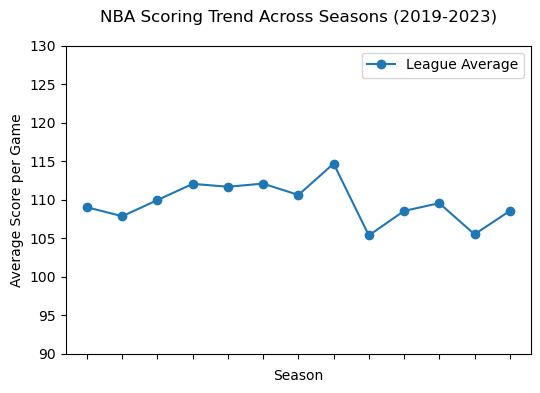

In [54]:
# visualization for introduction - average score across seasons

season_across_avg = team_season_avg.groupby('season_id')['points'].mean().reset_index()
plt.figure(figsize=(6,4))
plt.plot(season_across_avg['season_id'], season_across_avg['points'], label='League Average', marker='o')
plt.title('NBA Scoring Trend Across Seasons (2019-2023)', y=1.05)
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.ylim(90,130)
plt.xlabel('Season')
plt.ylabel('Average Score per Game')

plt.legend()
plt.show()

#### Rising Action

Our analysis showed that a league's average scoring was 111.92 points per game, establishing a clear benchmark for team performance evaluation. Using this threshold, our goal was to see which teams have had the most consecutive seasons averaging a score below the league standard  – potentially indicating systematic issues that could affect their value.

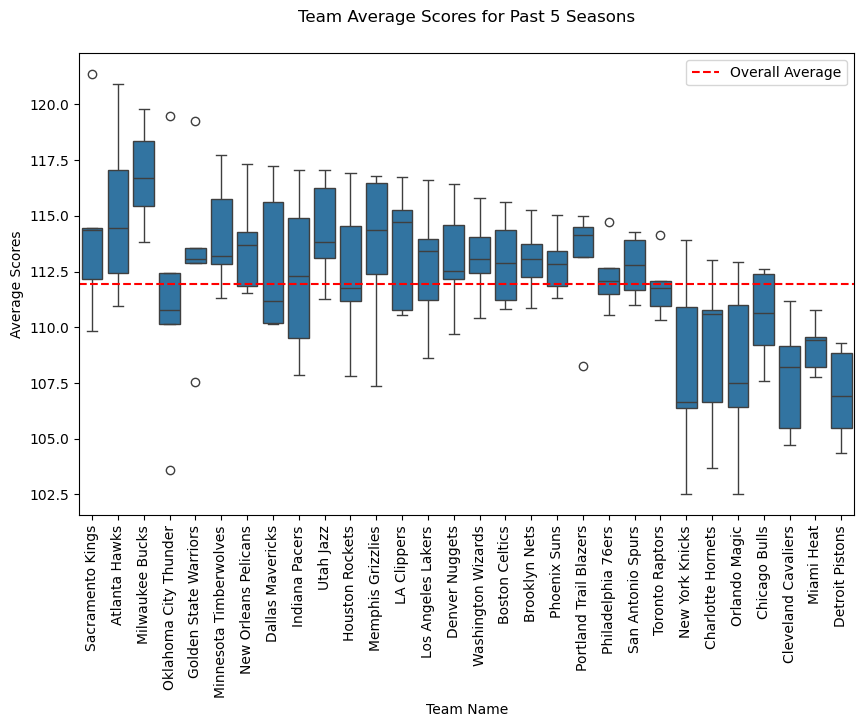

In [115]:
# visualization for rising action - team scores across seasons

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home', 'game_year'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away', 'game_year'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name', 'game_year']
score_stats_away.index.names = ['team_id', 'team_name', 'game_year']

combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name','game_year']).mean()
score_stats_all['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats_all = score_stats_all[score_stats_all['total_games'] >= 100]

team_order = score_stats_all.sort_values(by='mean', ascending=False).index.get_level_values('team_name').unique()

plt.figure(figsize=(10, 6))
sns.boxplot(data=score_stats_all.reset_index(), x="team_name", y="mean", order=team_order)

season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()
plt.axhline(y=season_avg, color='r', linestyle='--', label='Overall Average')

plt.title("Team Average Scores for Past 5 Seasons", y=1.05)
plt.xlabel('Team Name')
plt.ylabel('Average Scores')
plt.xticks(rotation='vertical')
plt.legend()

#### Climax

We discovered a striking contrast in scoring consistency across the NBA. The Orlando Magic and Detroit Pistons have notably struggled with scoring, each recording 9 consecutive seasons below the league average - a persistent challenge rather than a temporary slump. The Miami Heat and Cleveland Cavaliers followed with 7-season streaks, suggesting potential value opportunities if these playing challenges can be addressed. 

Meanwhile, teams like  Sacramento Kings, New Orleans Pelicans, and Golden State Warriors demonstrated remarkable offensive stability, rarely falling below the league average. This polarization suggests interesting investment implications: while struggling teams might offer value opportunities, consistently strong performers could represent safer, premium investments.

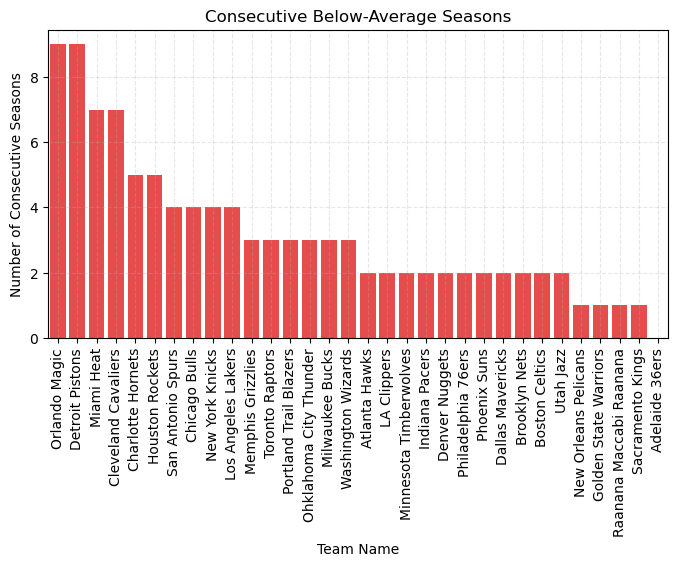

In [56]:
# visualization for climax

season_data = [['Orlando Magic', 9], ['Detroit Pistons', 9], ['Miami Heat', 7], ['Cleveland Cavaliers', 7], ['Charlotte Hornets', 5], ['Houston Rockets', 5], ['San Antonio Spurs', 4], ['Chicago Bulls', 4], ['New York Knicks', 4], ['Los Angeles Lakers', 4], ['Memphis Grizzlies', 3], ['Toronto Raptors', 3], ['Portland Trail Blazers', 3], ['Ohklahoma City Thunder', 3], ['Milwaukee Bucks', 3], ['Washington Wizards', 3], ['Atlanta Hawks', 2], ['LA Clippers', 2], ['Minnesota Timberwolves', 2], ['Indiana Pacers', 2], ['Denver Nuggets', 2], ['Philadelphia 76ers', 2], ['Phoenix Suns', 2], ['Dallas Mavericks', 2], ['Brooklyn Nets', 2], ['Boston Celtics', 2], ['Utah Jazz', 2], ['New Orleans Pelicans', 1], ['Golden State Warriors', 1], ['Raanana Maccabi Raanana', 1], ['Sacramento Kings', 1], ['Adelaide 36ers', 0]] 
consecutive_underperformance = pd.DataFrame(season_data, columns=['team_name', 'consecutive_seasons'])

plt.figure(figsize=(8, 4))
ax= sns.barplot(x='team_name', y='consecutive_seasons', data=consecutive_underperformance, color='red', alpha=0.8) 
ax.set_title('Consecutive Below-Average Seasons')
ax.set_ylabel('Number of Consecutive Seasons')
ax.set_xlabel('Team Name')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

#### Falling Action

There are many reasons a team can do poorly – from poor coaching, a poor player line-up, or insufficient financial support.  However, when we look for which teams had the least consecutive underperforming seasons, we can see that there are many teams that can turn it around within the 3 possible seasons types. This trend highlights a key market insight: a team's historical prestige or market size does not guarantee consistency in scoring capabilities, emphasizing that organization and player effectiveness is a critical factor in securing a game-win.

/var/folders/b2/t2bk4jsj6dz6nftdjx4m23w00000gn/T/ipykernel_5150/3867742764.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_teams['game_year_Q2'] = pd.to_datetime(selected_teams['game_date']).dt.year


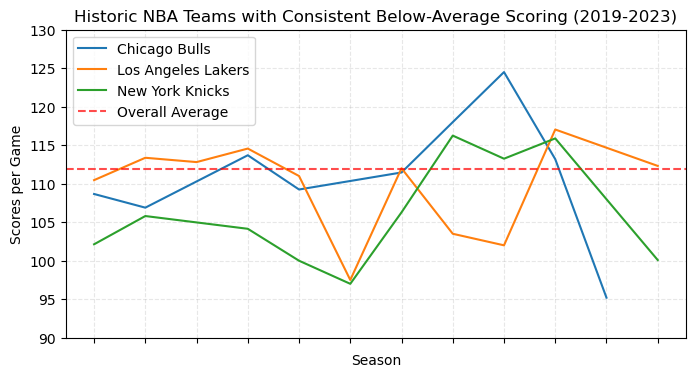

In [57]:
# visualization for falling action - historic teams with below-average scoring

season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

home_games = games_recent_5yrs[['season_id', 'team_id_home', 'team_name_home', 'pts_home', 'game_date']].rename(columns={
    'team_id_home': 'team_id',
    'team_name_home': 'team_name',
    'pts_home': 'points'
})
away_games = games_recent_5yrs[['season_id', 'team_id_away', 'team_name_away', 'pts_away', 'game_date']].rename(columns={
    'team_id_away': 'team_id',
    'team_name_away': 'team_name',
    'pts_away': 'points'
})
all_games = pd.concat([home_games, away_games])

team_season_avg = all_games.groupby(['season_id', 'team_id', 'team_name', 'game_date'])['points'].mean().reset_index()
selected_teams = team_season_avg[team_season_avg['team_name'].isin(['Chicago Bulls', 'New York Knicks', 'Los Angeles Lakers'])]
selected_teams['game_year_Q2'] = pd.to_datetime(selected_teams['game_date']).dt.year

yearly_avg_by_team = selected_teams.groupby(['game_year_Q2', 'season_id', 'team_name'])['points'].mean().reset_index()
yearly_avg_by_team = yearly_avg_by_team.sort_values('game_year_Q2')

plt.figure(figsize=(8, 4))
sns.lineplot(data=yearly_avg_by_team, x='season_id', y='points', hue='team_name', errorbar=None)

plt.axhline(y=season_avg, color='r', linestyle='--', label='Overall Average', alpha=0.7)
plt.ylim(90,130)

plt.title('Historic NBA Teams with Consistent Below-Average Scoring (2019-2023)')
plt.xlabel('Season')
plt.ylabel('Scores per Game')
plt.xticks(ticks=plt.xticks()[0], labels=[])

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.show()

#### Resolution

From an investment perspective, these struggling teams present contrasting opportunities:

1. Premium Investment (Sacramento Kings, Golden State Warriors, New Orleans Pelicans):
Consistently maintains above-average scoring performance
Offers lower risk with proven track record
2. High Risk/High Reward (Orlando Magic, Detroit Pistons, New York Knicks): 
Persistent below-average scoring performance
Significant turnaround potential if structural issues are addressed
Current valuations might reflect underperformance

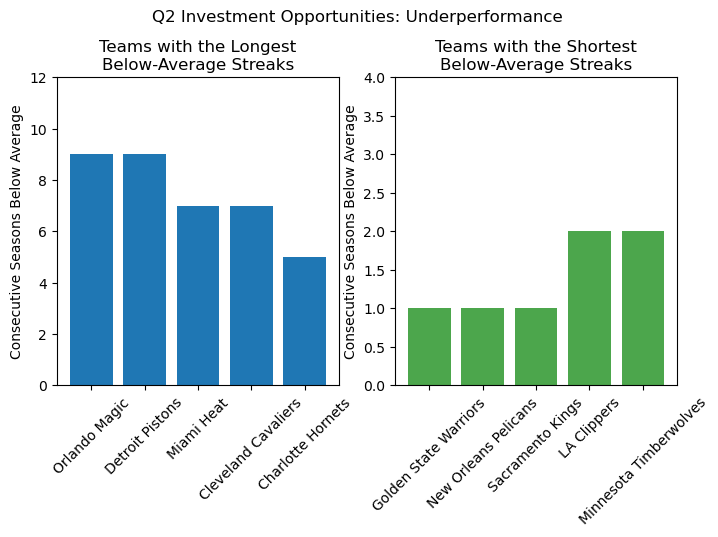

In [58]:
# visualization for resolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# top 5 longest below average streaks
top5_longest = team_streaks.sort_values(ascending=False).head(5)
ax1.bar(top5_longest.index, top5_longest.values)
ax1.set_title('Teams with the Longest\nBelow-Average Streaks')
ax1.set_ylim(0, 12)
ax1.set_ylabel('Consecutive Seasons Below Average')

# top 5 shortest below average streaks
team_streaks_filtered = team_streaks.sort_values(ascending=True)
top5_shortest = team_streaks_filtered.iloc[2:].head(5)
ax2.bar(top5_shortest.index, top5_shortest.values, color='green', alpha=0.7)
ax2.set_title('Teams with the Shortest\nBelow-Average Streaks')
ax2.set_ylim(0, 4)
ax2.set_ylabel('Consecutive Seasons Below Average')
plt.sca(ax1)
plt.xticks(rotation=45)
plt.sca(ax2)
plt.xticks(rotation=45)
plt.suptitle('Q2 Investment Opportunities: Underperformance', y=1.05)
plt.show()

#### Q3: Which team has consistently made it to the playoffs?

In [59]:
# playoff games
playoff_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Playoffs']

# playoff appearances (seasons)
playoff_home_seasons = playoff_games[['season_id', 'team_name_home']].rename(
   columns={'team_name_home': 'team_name'}).drop_duplicates()
playoff_away_seasons = playoff_games[['season_id', 'team_name_away']].rename(
   columns={'team_name_away': 'team_name'}).drop_duplicates()
all_playoff_seasons = pd.concat([playoff_home_seasons, playoff_away_seasons]).drop_duplicates()
playoff_appearances = all_playoff_seasons.groupby('team_name').size().sort_values(ascending=False)

# total playoff games (games)
playoff_home_games = playoff_games[['team_name_home', 'game_id']].rename(
   columns={'team_name_home': 'team_name'})
playoff_away_games = playoff_games[['team_name_away', 'game_id']].rename(
   columns={'team_name_away': 'team_name'})
all_playoff_games = pd.concat([playoff_home_games, playoff_away_games])
playoff_games_count = all_playoff_games.groupby('team_name').size()
print(playoff_games_count.head(5))

# playoff appearances, for both seasons & games
playoff_all = pd.DataFrame({
    'team_name': playoff_appearances.index,
    'seasons': playoff_appearances.values,
    'total_games': playoff_games_count[playoff_appearances.index].values
}) 
print(playoff_all.head(5))

# average playoff game per season 
playoff_all['games_per_season'] = (playoff_all['total_games'] / playoff_all['seasons'])

# playoff appearance rate   
total_seasons = games_recent_5yrs['season_id'].nunique()
playoff_all['appearance_rate'] = (playoff_all['seasons'] / total_seasons * 100)

# playoff win percentage
home_wins = playoff_games[playoff_games['wl_home'] == 'W'][['team_name_home', 'game_id']].rename(
   columns={'team_name_home': 'team_name'})
away_wins = playoff_games[playoff_games['wl_away'] == 'W'][['team_name_away', 'game_id']].rename(
   columns={'team_name_away': 'team_name'})
all_wins = pd.concat([home_wins, away_wins])
playoff_wins_count = all_wins.groupby('team_name').size()

playoff_all['win_percentage'] = (playoff_wins_count.reindex(playoff_all['team_name']).fillna(0).values / playoff_all['total_games'] * 100)

# average playoff game per season 
playoff_all['games_per_season'] = (playoff_all['total_games'] / playoff_all['seasons'])

print("\nPlayoff appearances and performance (2019-2023):")
print(playoff_all[['team_name', 'seasons', 'appearance_rate', 'total_games', 'games_per_season', 'win_percentage']]
     .sort_values(by='total_games',ascending=False).head(20))


team_name
Atlanta Hawks          29
Boston Celtics         75
Brooklyn Nets          29
Chicago Bulls           5
Cleveland Cavaliers     5
dtype: int64
            team_name  seasons  total_games
0       Brooklyn Nets        5           29
1      Denver Nuggets        5           68
2  Philadelphia 76ers        5           51
3     Milwaukee Bucks        5           65
4      Boston Celtics        5           75

Playoff appearances and performance (2019-2023):
                 team_name  seasons  appearance_rate  total_games  \
4           Boston Celtics        5        38.461538           75   
1           Denver Nuggets        5        38.461538           68   
5               Miami Heat        4        30.769231           66   
3          Milwaukee Bucks        5        38.461538           65   
14   Golden State Warriors        3        23.076923           57   
2       Philadelphia 76ers        5        38.461538           51   
11            Phoenix Suns        3        23.0769

#### Introduction

In the NBA, playoff success is a crucial indicator of a team's value and investment potential. Making the playoffs not only validates a team's competitiveness but also drives revenue through ticket sales, merchandise, and media exposure. We analyzed playoff performance from 2019-2023 to identify which teams have demonstrated the most reliable postseason presence and how this might inform investment decisions.

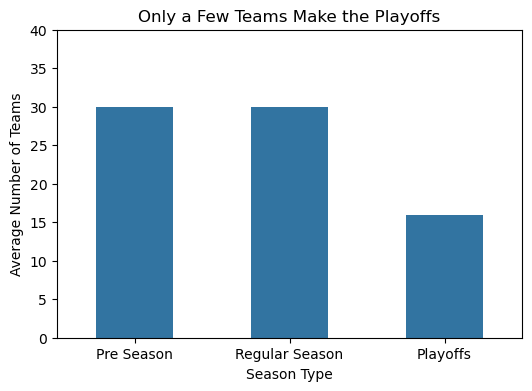

In [61]:
# visualization for introduction

unique_teams = games_recent_5yrs.groupby(['season_id', 'season_type'])['team_name_home'].nunique()
avg_unique_teams = unique_teams.groupby('season_type').mean()
season_order = ['Pre Season', 'Regular Season', 'Playoffs']
avg_unique_teams = avg_unique_teams.reindex(season_order)
plt.figure(figsize=(6, 4))
sns.barplot(x=avg_unique_teams.index, y=avg_unique_teams.values, width=0.5)
plt.title('Only a Few Teams Make the Playoffs')
plt.xlabel('Season Type')
plt.ylabel('Average Number of Teams')
plt.ylim(0,40)
plt.show()

#### Rising action

Our analysis revealed interesting patterns in playoff participation. Five teams - the Brooklyn Nets, Denver Nuggets, Philadelphia 76ers, Milwaukee Bucks, and Boston Celtics - achieved a perfect record, making the playoffs in all five seasons. This consistent postseason presence suggests strong organizational stability and reliable performance.

However, playoff appearances alone don't tell the complete story. To truly understand a team's postseason success and potential investment value, we needed to examine how deep these teams went in the playoffs. This meant looking at the total number of playoff games played, which indicates both consistency and championship potential.

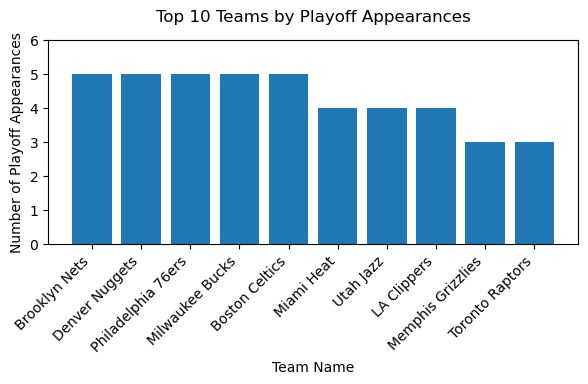

In [62]:
# visualization for rising action

playoff_top_teams = playoff_all.head(10)
plt.figure(figsize=(6, 4))
plt.bar(playoff_top_teams['team_name'], playoff_top_teams['seasons'])
plt.title('Top 10 Teams by Playoff Appearances', y=1.05)
plt.xlabel('Team Name')
plt.ylabel('Number of Playoff Appearances')
plt.ylim(0,6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Climax

During 2019-2023, the Boston Celtics led all teams with 75 playoff games, followed by the Denver Nuggets (68 games) and Miami Heat (66 games). Both the Boston Celtics and Denver Nuggets maintained perfect playoff attendance while achieving high win rates (54.7% and 54.4% respectively), demonstrating consistent excellence. 
The Golden State Warriors’ performance is particularly impressive, reaching 57 games in just 3 playoff appearances (19 average games per season) and the highest win percentage (63%), suggesting they went deep in every playoff they were present.  The Milwaukee Bucks round out the top performers with 65 games and the win percentage (60%) among frequent playoff teams. These metrics showcase why these teams stand out as the NBA's most reliable playoff performers, making them particularly attractive from both competitive and investment perspectives.

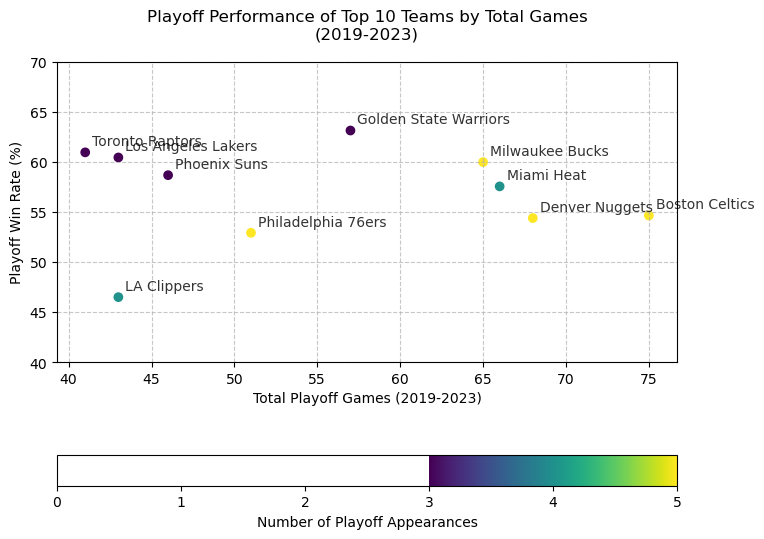

In [63]:
# visualization for climax

top_10_teams_q3 = playoff_all.nlargest(10, 'total_games')
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(top_10_teams_q3['total_games'], top_10_teams_q3['win_percentage'],
          c=top_10_teams_q3['seasons'])
for idx, row in top_10_teams_q3.iterrows():
    ax.annotate(row['team_name'],
                xy=(row['total_games'], row['win_percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                alpha=0.8)
plt.xlabel('Total Playoff Games (2019-2023)')
plt.ylabel('Playoff Win Rate (%)')
plt.title('Playoff Performance of Top 10 Teams by Total Games\n(2019-2023)', y=1.05)
plt.ylim(40,70)
plt.grid(True, linestyle='--', alpha=0.7)
cbar = plt.colorbar(scatter, orientation='horizontal', 
                  label='Number of Playoff Appearances',
                  pad=0.2)
cbar.set_ticks(range(6))
plt.show()

#### Falling action

On the opposite end of the spectrum, eight teams struggled with playoff consistency, making only one appearance in five years. These included established franchises like the Chicago Bulls (5 games) and Detroit Pistons (4 games). This stark contrast in performance highlights the significant gap between the league's most and least successful teams in terms of postseason achievement.
The data also reveals that historical prestige doesn't guarantee current success, even teams with rich playoff histories can face extended periods of postseason struggles.

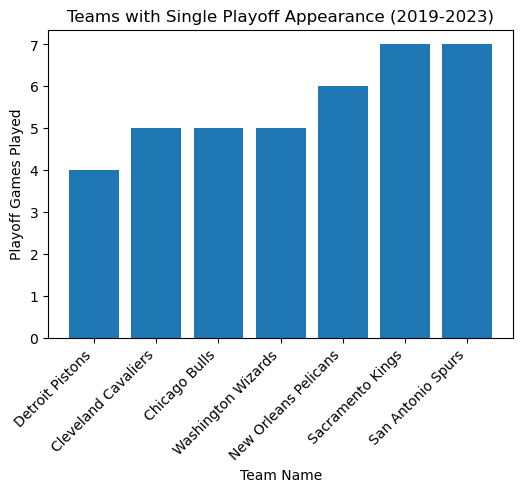

In [64]:
# visualization for falling action

plt.figure(figsize=(6, 4))
playoffs_struggling_teams = playoff_all[playoff_all['seasons'] == 1].sort_values('total_games')
bars = plt.bar(playoffs_struggling_teams['team_name'], playoffs_struggling_teams['total_games'])
plt.title('Teams with Single Playoff Appearance (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Playoff Games Played')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Resolution

Based on our analysis, here are the key investment recommendations:

1. Premier Investments (Boston Celtics, Denver Nuggets): Highest playoff game count with perfect attendance, Consistent win rates above 54%, Most reliable returns through consistent playoff success
2. High-Efficiency Plays (Golden State Warriors, Miami Heat): Exceptional playoff performance when qualifying, League-leading win percentages (63% and 57.5%), Strong potential for deep playoff runs despite fewer appearances
3. Stable Value (Milwaukee Bucks, Philadelphia 76ers): Consistent playoff presence, Solid win percentages (60% and 52.9%), Demonstrated potential to advance in postseason

The Boston Celtics and Denver Nuggets stand out as the most attractive investment options, combining reliable playoff qualification with consistent deep runs. The Golden State Warriors' exceptional efficiency metrics suggest particularly strong returns during playoff years, though with slightly higher volatility due to fewer appearances.


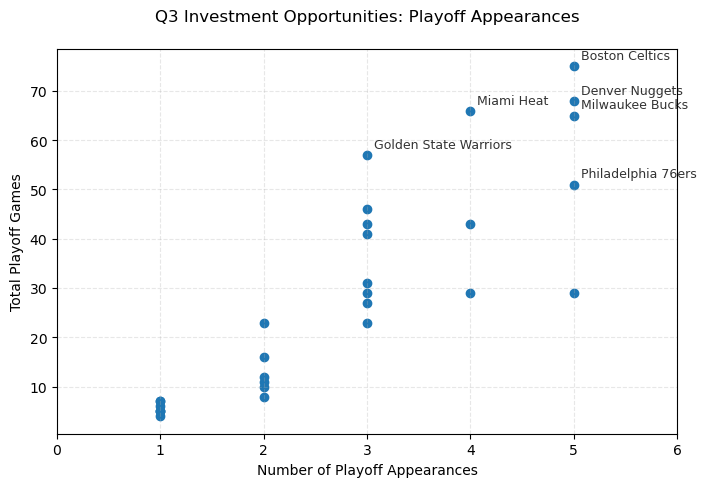

In [65]:
# visualization for resolution

plt.figure(figsize=(8, 5))
plt.scatter(playoff_all['seasons'], playoff_all['total_games'])
teams_of_interest_q3 = ['Boston Celtics', 'Denver Nuggets', 'Golden State Warriors', 
                    'Miami Heat', 'Milwaukee Bucks', 'Philadelphia 76ers']
for idx, row in playoff_all[playoff_all['team_name'].isin(teams_of_interest_q3)].iterrows():
   plt.annotate(row['team_name'],
               xy=(row['seasons'], row['total_games']),
               xytext=(5, 5),
               textcoords='offset points',
               fontsize=9,
               alpha=0.8)
plt.xlabel('Number of Playoff Appearances')
plt.ylabel('Total Playoff Games')
plt.xlim(0,6)
plt.title('Q3 Investment Opportunities: Playoff Appearances', y=1.05)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

#### Q4: Which teams have shown the greatest improvement over the past five years?

In [87]:
# extract year from game_date
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

# limit to regular season
regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home and away game data 
reg_home_games = regular_games[['team_name_home', 'game_year', 'pts_home']].rename(
    columns={'team_name_home': 'team_name', 'pts_home': 'points'})
reg_away_games = regular_games[['team_name_away', 'game_year', 'pts_away']].rename(
    columns={'team_name_away': 'team_name', 'pts_away': 'points'})
reg_all_games = pd.concat([reg_home_games, reg_away_games])

# average points for each team by year
team_year_avg = reg_all_games.groupby(['team_name', 'game_year'])['points'].mean().reset_index()

# improvement
improvement_list = []

for team in team_year_avg['team_name'].unique():
    team_data = team_year_avg[team_year_avg['team_name'] == team].sort_values('game_year')
    
    total_improvement = team_data['points'].diff().sum() 
    
    improvement_list.append({
        'team_name_home': team, 
        'total_improvement': total_improvement
    })

team_improvement = pd.DataFrame(improvement_list)
team_improvement = team_improvement.sort_values(by='total_improvement', ascending=False)

print("Teams with the greatest improvement over the past five years:")
print(team_improvement.head(20))

Teams with the greatest improvement over the past five years:
            team_name_home  total_improvement
19         New York Knicks          14.695726
25        Sacramento Kings          12.650000
14       Memphis Grizzlies          10.526330
0            Atlanta Hawks           9.028261
11          Indiana Pacers           8.326020
9    Golden State Warriors           7.655134
5      Cleveland Cavaliers           7.627350
13      Los Angeles Lakers           6.813824
20   Oklahoma City Thunder           6.298844
21           Orlando Magic           5.524613
7           Denver Nuggets           5.377463
4            Chicago Bulls           5.149422
1           Boston Celtics           4.875494
28               Utah Jazz           4.740310
22      Philadelphia 76ers           4.458629
6         Dallas Mavericks           4.343460
3        Charlotte Hornets           4.276423
17  Minnesota Timberwolves           4.053968
12             LA Clippers           2.143659
15              Mi

#### Introduction

A team's ability to improve year after year can be used to predict their future potential. Our previous data has discussed which teams have done 'best' historically, this doesn’t take into consideration which teams may surprise us in the upcoming season. We analyzed scoring patterns from 2019-2023 to identify teams showing the strongest upward trajectories.

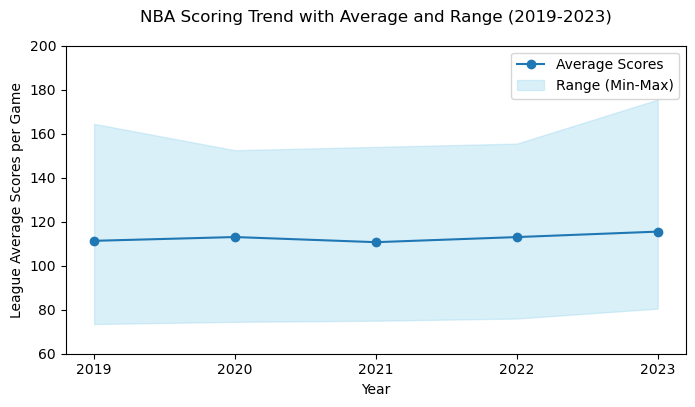

In [88]:
# visualization for introduction

plt.figure(figsize=(8,4))
yearly_stats = regular_games.groupby('game_year').agg({
    'pts_home' : ['mean', 'min', 'max'],
    'pts_away' : ['mean', 'min', 'max']
}).reset_index()
yearly_stats.columns = ['game_year', 'mean_home', 'min_home', 'max_home', 'mean_away', 'min_away', 'max_away']
yearly_stats['points_mean'] = (yearly_stats['mean_home'] + yearly_stats['mean_away']) / 2
yearly_stats['points_min'] = (yearly_stats['min_home'] + yearly_stats['min_away']) / 2
yearly_stats['points_max'] = (yearly_stats['max_home'] + yearly_stats['max_away']) / 2
yearly_avg['game_year'] = yearly_avg['game_year'].astype(int)
plt.plot(yearly_stats['game_year'], yearly_stats['points_mean'], marker='o', label='Average Scores')
plt.fill_between(yearly_stats['game_year'], 
                 yearly_stats['points_min'], 
                 yearly_stats['points_max'], 
                 color='skyblue', alpha=0.3, label='Range (Min-Max)')
plt.xticks(yearly_avg['game_year'])
plt.title('NBA Scoring Trend with Average and Range (2019-2023)', y=1.05) # y=1.05 added
plt.xlabel('Year')
plt.ylabel('League Average Scores per Game')
plt.ylim(60,200)
plt.legend()
plt.show()

#### Rising action

Looking at regular season games, we discovered interesting patterns in scoring trends. According to the boxplot, the median score has shown a gradual increase from 2019 to 2023. Moreover, the lower end of the box, representing the 25th percentile, indicates that the scoring of the bottom 25% of teams has also risen steadily over the years.

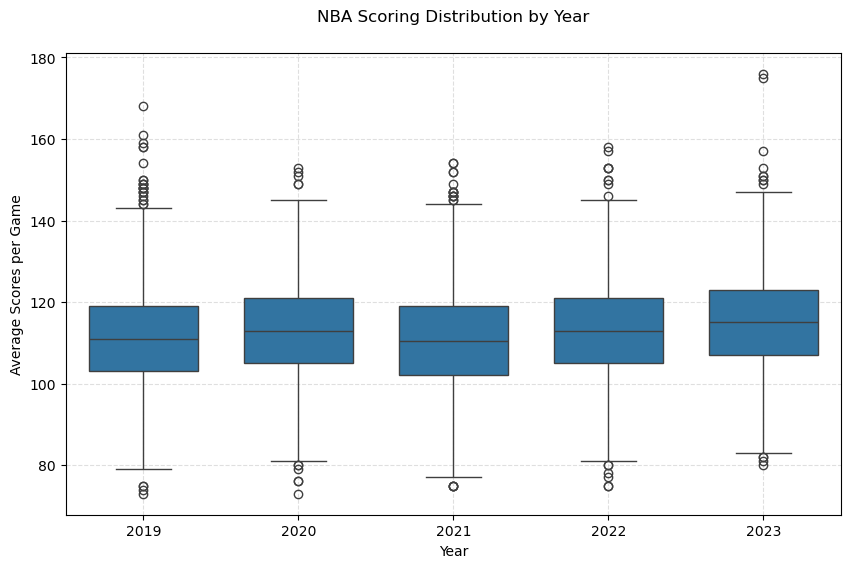

In [89]:
# visualization for rising action

plt.figure(figsize=(10, 6))
sns.boxplot(data=reg_all_games, x='game_year', y='points', width=0.7)
plt.title('NBA Scoring Distribution by Year', y=1.05)
plt.xlabel('Year')
plt.ylabel('Average Scores per Game')
plt.grid(True, linestyle='--', alpha=0.4)

#### Climax

Looking at the data, we uncovered remarkable developments in several NBA teams' scoring capabilities, both positive and negative. The New York Knicks indicated the most improvement with a 14.7-point increase in points-per-game. This was followed by Sacramento Kings and Memphis Grizzlies. In contrast, The Houston Rockets have indicated a decrease in point potential within the past 5 years.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'New York Knicks'),
  Text(1, 0, 'Sacramento Kings'),
  Text(2, 0, 'Memphis Grizzlies'),
  Text(3, 0, 'Atlanta Hawks'),
  Text(4, 0, 'Indiana Pacers'),
  Text(5, 0, 'Golden State Warriors'),
  Text(6, 0, 'Cleveland Cavaliers'),
  Text(7, 0, 'Los Angeles Lakers'),
  Text(8, 0, 'Oklahoma City Thunder'),
  Text(9, 0, 'Orlando Magic'),
  Text(10, 0, 'Denver Nuggets'),
  Text(11, 0, 'Chicago Bulls'),
  Text(12, 0, 'Boston Celtics'),
  Text(13, 0, 'Utah Jazz'),
  Text(14, 0, 'Philadelphia 76ers'),
  Text(15, 0, 'Dallas Mavericks'),
  Text(16, 0, 'Charlotte Hornets'),
  Text(17, 0, 'Minnesota Timberwolves'),
  Text(18, 0, 'LA Clippers'),
  Text(19, 0, 'Miami Heat'),
  Text(20, 0, 'Detroit Pistons'),
  Text(21, 0, 'San Antonio Spurs'),
  Text(22, 0, 'Phoenix Suns'),
  Text(23, 0, 'Milwaukee Bucks'),
  Text(24, 0,

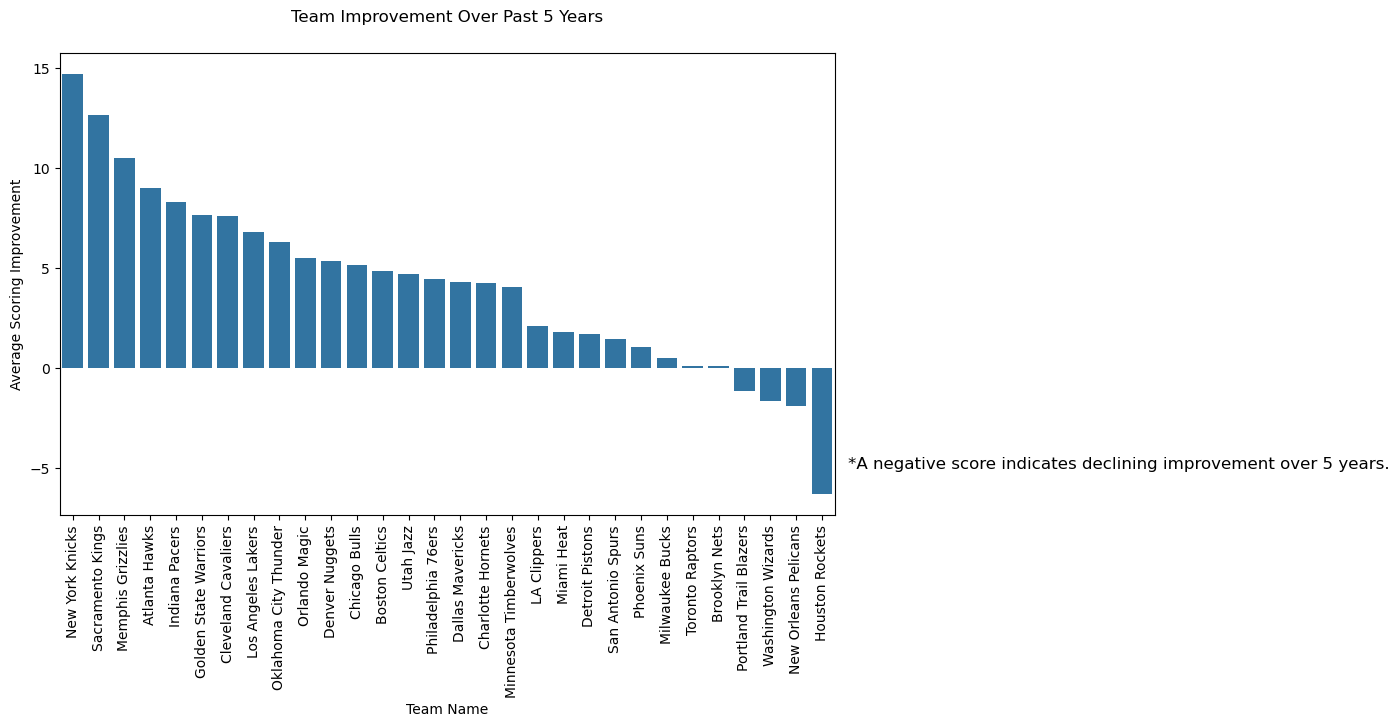

In [90]:
# visualization for climax

plt.figure(figsize=(10, 6)) 
ax2= sns.barplot(x='team_name_home', y='total_improvement', data=team_improvement)
plt.title('Team Improvement Over Past 5 Years', y=1.05)
plt.text(30, -5, '*A negative score indicates declining improvement over 5 years.', fontsize=12)
ax2.set_ylabel('Average Scoring Improvement')
ax2.set_xlabel('Team Name')
plt.xticks(rotation=90)

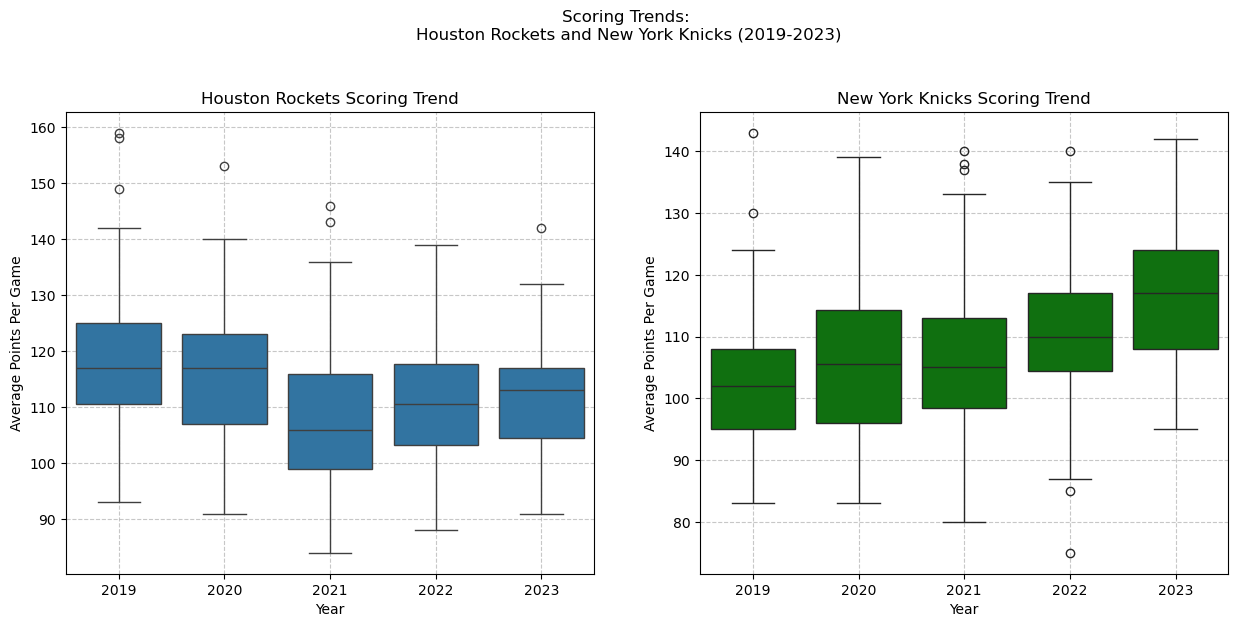

In [91]:
# visualization for climax - houston rockets & ny knicks 

hr_improve = reg_all_games[reg_all_games['team_name'] == 'Houston Rockets']
nyk_improve = reg_all_games[reg_all_games['team_name'] == 'New York Knicks']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=hr_improve, x='game_year', y='points', ax=ax1)
ax1.set_title('Houston Rockets Scoring Trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Points Per Game')

sns.boxplot(data=nyk_improve, x='game_year', y='points', ax=ax2, color='green')
ax2.set_title('New York Knicks Scoring Trend')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Points Per Game')

fig.suptitle('Scoring Trends: \nHouston Rockets and New York Knicks (2019-2023)', y=1.05)
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Falling action

What this data is aiming to explain is a team’s ability to strategize and improve. Rather than showing gradual, year-over-year progress, both the New York Knicks and Sacramento Kings displayed sharp inflection points in their scoring output. Their leap from a bottom-tier offensive team to leading the league in improvement showcased successful strategic shifts that could rapidly alter a team's performance ceiling.

In [94]:
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

# limit to regular season
regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home and away game data 
reg_home_games = regular_games[['team_name_home', 'game_year', 'pts_home']].rename(
    columns={'team_name_home': 'team_name', 'pts_home': 'points'})
reg_away_games = regular_games[['team_name_away', 'game_year', 'pts_away']].rename(
    columns={'team_name_away': 'team_name', 'pts_away': 'points'})
reg_all_games = pd.concat([reg_home_games, reg_away_games])

# average points for each team by year
team_year_avg = reg_all_games.groupby(['team_name', 'game_year'])['points'].mean().reset_index()

# improvement
improvement_list = []
for team in team_year_avg['team_name'].unique():
    team_data = team_year_avg[team_year_avg['team_name'] == team].sort_values('game_year')
    
    total_improvement = team_data['points'].diff().sum() 
    
    improvement_list.append({
        'team_name': team, 
        'total_improvement': total_improvement
    })
team_improvement = pd.DataFrame(improvement_list)
team_improvement = team_improvement.sort_values(by='total_improvement', ascending=False)

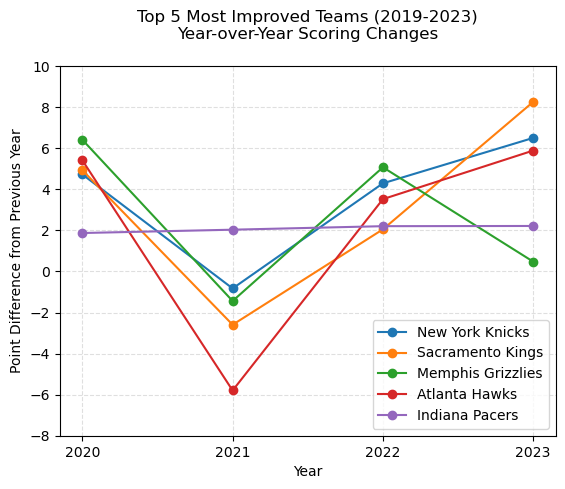

In [95]:
# visualization for falling action - yoy scoring changes

top_5_q4 = team_improvement.sort_values(by='total_improvement', ascending=False)
top_5_q4 = team_improvement.head(5)['team_name']
for team in top_5_q4:
    team_data = team_year_avg[team_year_avg['team_name']==team]
    team_data = team_data.sort_values('game_year')
    changes = team_data['points'].diff()
    plt.plot(team_data['game_year'][1:], changes[1:], marker='o', label=team)
plt.title('Top 5 Most Improved Teams (2019-2023)\nYear-over-Year Scoring Changes', y=1.05)
plt.xlabel('Year')
plt.ylabel('Point Difference from Previous Year')
plt.xticks([2020, 2021, 2022, 2023])
plt.ylim(-8,10)
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.4)
plt.show()

#### Resolution

Teams who haven’t shown much improvement or have even decreased their scoring ability may still be historical winners. Improvements highlight teams that have successfully modernized their approach – teams that can be winners in the future. The New York Knicks and Sacramento Kings, in particular, have demonstrated the ability to significantly enhance their scoring output, suggesting potential for continued growth and value appreciation.

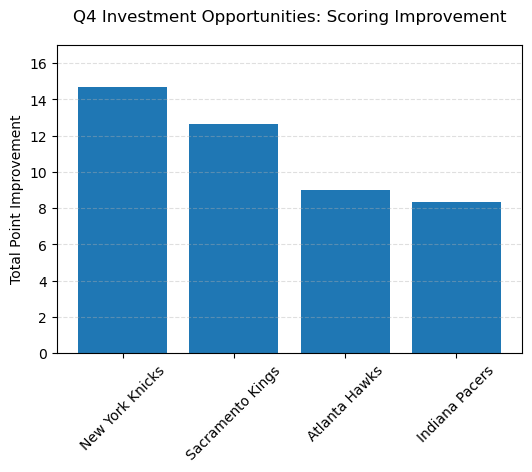

In [96]:
# visualization for resolution

teams_of_interest_q4 = ['New York Knicks', 'Sacramento Kings', 'Atlanta Hawks', 'Indiana Pacers']
team_data_q4 = team_improvement[team_improvement['team_name'].isin(teams_of_interest_q4)]
plt.figure(figsize=(6, 4))
plt.bar(team_data_q4['team_name'], team_data_q4['total_improvement'])
plt.title('Q4 Investment Opportunities: Scoring Improvement', y=1.05)
plt.ylabel('Total Point Improvement')
plt.xticks(rotation=45)
plt.ylim(0,17)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

#### Q5: Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?

In [97]:
# home games stats
home_defense = regular_games[['team_name_home', 'blk_home', 'stl_home', 'wl_home']].rename(
   columns={'team_name_home': 'team_name', 
           'blk_home': 'blocks',
           'stl_home': 'steals',
           'wl_home': 'win_loss'})

# away games stats
away_defense = regular_games[['team_name_away', 'blk_away', 'stl_away', 'wl_away']].rename(
   columns={'team_name_away': 'team_name',
           'blk_away': 'blocks', 
           'stl_away': 'steals',
           'wl_away': 'win_loss'})

# defense metrics
all_defense = pd.concat([home_defense, away_defense])
defense_stats = all_defense.groupby('team_name').agg(
    avg_blocks=('blocks', 'mean'),
    avg_steals=('steals', 'mean')
).reset_index()

# win rate 
wins = all_defense[all_defense['win_loss'] == 'W'].groupby('team_name').size()
total_games = all_defense.groupby('team_name').size()
win_rates = (wins / total_games).reset_index(name='win_rate')

# combined blocks & steals # changed
defense_analysis = pd.merge(defense_stats, win_rates, on='team_name')
defense_analysis['combined_blocks_steals'] = defense_analysis['avg_blocks'] + defense_analysis['avg_steals'] # changed
defense_sorted = defense_analysis.sort_values(
   by=['combined_blocks_steals', 'win_rate'], # changed
   ascending=[False, False]
)

print("Teams with the best defensive metrics:")
print(defense_sorted.head(10))

Teams with the best defensive metrics:
                 team_name  avg_blocks  avg_steals  win_rate  \
14       Memphis Grizzlies    5.619718    8.653521  0.546479   
27         Toronto Raptors    5.036932    8.914773  0.568182   
17  Minnesota Timberwolves    5.397101    8.423188  0.431884   
22      Philadelphia 76ers    5.336158    8.050847  0.635593   
11          Indiana Pacers    5.576271    7.731638  0.457627   
1           Boston Celtics    5.485876    7.502825  0.621469   
13      Los Angeles Lakers    5.355114    7.508523  0.528409   
9    Golden State Warriors    4.713043    8.043478  0.530435   
10         Houston Rockets    4.810734    7.892655  0.381356   
23            Phoenix Suns    4.628895    7.824363  0.577904   

    combined_blocks_steals  
14               14.273239  
27               13.951705  
17               13.820290  
22               13.387006  
11               13.307910  
1                12.988701  
13               12.863636  
9                12.7565

#### Introduction

In the NBA, defensive prowess is often the foundation for championship success. To uncover the impact of defense on team performance, we analyzed key defensive metrics-blocks and steals- from 2019 to 2023. Our goal was to identify teams that not only excel defensively but also maintain consistent winning records. While offensive statistics often dominate headlines, our analysis reveals the role defense plays in driving victories. These insights provide a data-driven perspective, aiding more informed decisions about team valuation and investment strategies.

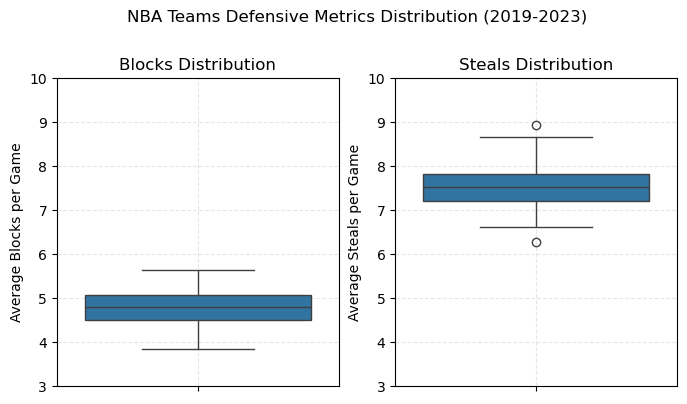

In [101]:
# visualization for introduction - league-wide defense distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('NBA Teams'' Defensive Metrics Distribution (2019-2023)', y=1.05)

# blocks
sns.boxplot(data=defense_analysis, y='avg_blocks', ax=ax1)
ax1.set_title('Blocks Distribution') 
ax1.set_ylabel('Average Blocks per Game')
ax1.set_ylim(3,10)
plt.sca(ax1)
plt.grid(True, linestyle='--', alpha=0.3)

# steals
sns.boxplot(data=defense_analysis, y='avg_steals', ax=ax2)
ax2.set_title('Steals Distribution')
ax2.set_ylabel('Average Steals per Game')
ax2.set_ylim(3,10)
plt.sca(ax2)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

#### Rising action

Our analysis uncovered compelling defensive patterns across NBA teams. The Memphis Grizzlies demonstrated exceptional defensive metrics, leading with 5.62 blocks and 8.65 steals per game, while the Toronto Raptors excelled specifically in steals with 8.91 per game. These metrics stand out historically, but they raise critical investment questions.

To truly understand the investment potential, we needed to look beyond raw defensive statistics. How well do these defensive metrics translate to actual team success? Are teams with elite defensive numbers consistently outperforming the market? By examining the correlation between defensive prowess and winning percentage, we aim to identify teams that combine defensive excellence with proven success - a potential indicator of sustainable long-term value.

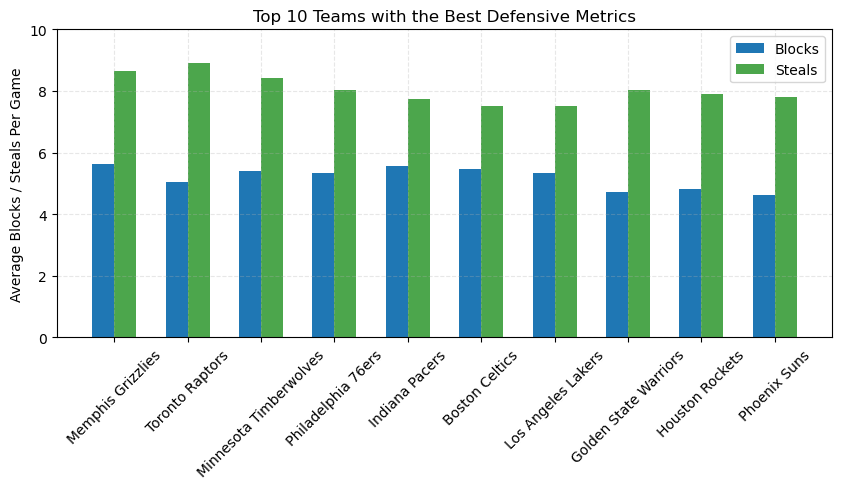

In [102]:
# visualization for rising action

top_10_defense = defense_sorted.sort_values('combined_blocks_steals', ascending=False).head(10)
plt.figure(figsize=(10, 4))

# grouped bar chart
x = range(len(top_10_defense['team_name']))
width = 0.3
plt.bar(x, top_10_defense['avg_blocks'], width, label='Blocks')
plt.bar([i + width for i in x], top_10_defense['avg_steals'], width, label='Steals', color='green', alpha=0.7)
plt.ylabel('Average Blocks / Steals Per Game')
plt.title('Top 10 Teams with the Best Defensive Metrics')
plt.xticks([i + width/2 for i in x], top_10_defense['team_name'], rotation=45)
plt.ylim(0,10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

#### Climax 1

The data reveals a compelling investment story through defensive metrics and winning consistency. The Milwaukee Bucks emerge as the top performer with a league-leading 69.1% win rate while maintaining solid defensive numbers (5.0 blocks, 7.4 steals). Following closely, the Philadelphia 76ers demonstrate exceptional defensive capabilities with 5.3 blocks and 8.1 steals, translating to a 63.6% win rate. The Denver Nuggets and Boston Celtics round out the top tier, each converting strong defensive metrics into win rates above 62%.
Particularly noteworthy is that while teams like the Toronto Raptors show superior defensive statistics (ranking highest in total defense rating at 13.95), their lower win rate (56.8%) suggests challenges in converting defensive excellence into consistent victories.

This pattern indicates that for investment purposes, teams successfully balancing defensive capabilities with winning consistency, like the Bucks and 76ers, represent more stable investment opportunities.

Text(0.5, 1.05, 'Defensive Performance and Win Rate by Team')

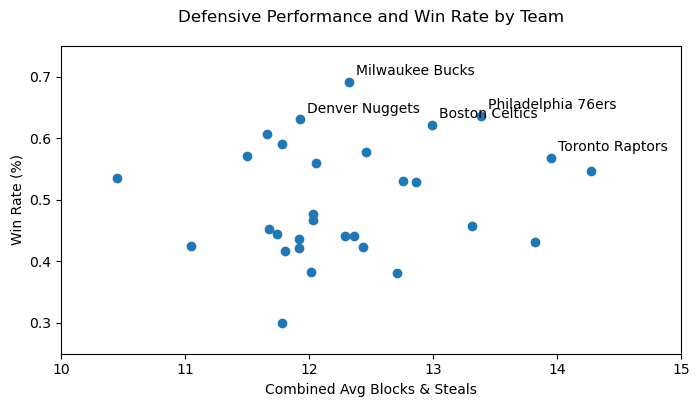

In [104]:
# visualization for climax 1

plt.figure(figsize=(8, 4))
plt.scatter(defense_sorted['combined_blocks_steals'], 
           defense_sorted['win_rate'])

key_teams = ['Milwaukee Bucks', 'Philadelphia 76ers', 'Denver Nuggets', 
            'Boston Celtics', 'Toronto Raptors']
for _, team in defense_sorted[defense_sorted['team_name'].isin(key_teams)].iterrows():
    plt.annotate(team['team_name'], 
                (team['combined_blocks_steals'], team['win_rate']), 
                xytext=(5, 5), 
                textcoords='offset points')
plt.ylim(0.25,0.75)
plt.xlim(10,15)
plt.xlabel('Combined Avg Blocks & Steals')
plt.ylabel('Win Rate (%)')
plt.title('Defensive Performance and Win Rate by Team', y=1.05)


#### Climax 2

Analysis reveals surprisingly weak correlations between defensive metrics and winning performance, with blocks (0.223), steals (0.061), and overall defense rating (0.167) showing minimal correlation with win rates. The scatter plots visualize this disconnect clearly - teams with high defensive ratings frequently fail to achieve corresponding win rates.

These findings challenge conventional wisdom about defensive metrics as team performance indicators. For instance, while the Toronto Raptors excel in defensive statistics, their lower win rate demonstrates that defensive prowess alone doesn't guarantee success. The scattered distribution across all metrics suggests investors need a more comprehensive evaluation framework beyond defensive capabilities to assess team potential.

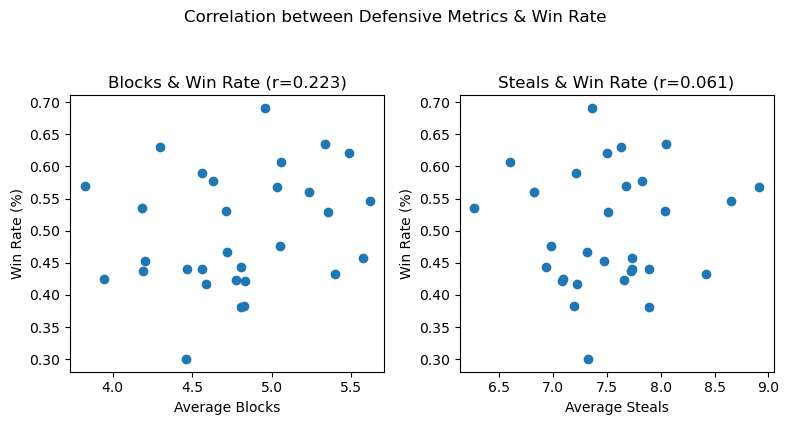

In [107]:
# visualization for climax 2

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(defense_analysis['avg_blocks'], defense_analysis['win_rate'])
ax1.set_title('Blocks & Win Rate (r=0.223)')
ax1.set_xlabel('Average Blocks')
ax1.set_ylabel('Win Rate (%)')

ax2.scatter(defense_analysis['avg_steals'], defense_analysis['win_rate'])
ax2.set_title('Steals & Win Rate (r=0.061)')
ax2.set_xlabel('Average Steals')
ax2.set_ylabel('Win Rate (%)')

plt.suptitle('Correlation between Defensive Metrics & Win Rate', y=1.05)
plt.tight_layout()
plt.show()

#### Falling Action

The disconnect between defensive metrics and win rates has significant market implications. Valuation heavily weighing defensive statistics may be overvaluing certain teams while missing other investment opportunities. This misalignment creates potential market inefficiencies, particularly in teams like the Milwaukee Bucks and Philadelphia 76ers, who demonstrate success beyond pure defensive excellence. Moreover, teams focusing solely on defensive improvement might be misallocating resources, suggesting a need for a more balanced approach to team development and valuation.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Phoenix Suns'),
  Text(1, 0, 'Boston Celtics'),
  Text(2, 0, 'Philadelphia 76ers'),
  Text(3, 0, 'Golden State Warriors'),
  Text(4, 0, 'Los Angeles Lakers'),
  Text(5, 0, 'Toronto Raptors'),
  Text(6, 0, 'Indiana Pacers'),
  Text(7, 0, 'Houston Rockets'),
  Text(8, 0, 'Memphis Grizzlies'),
  Text(9, 0, 'Minnesota Timberwolves')])

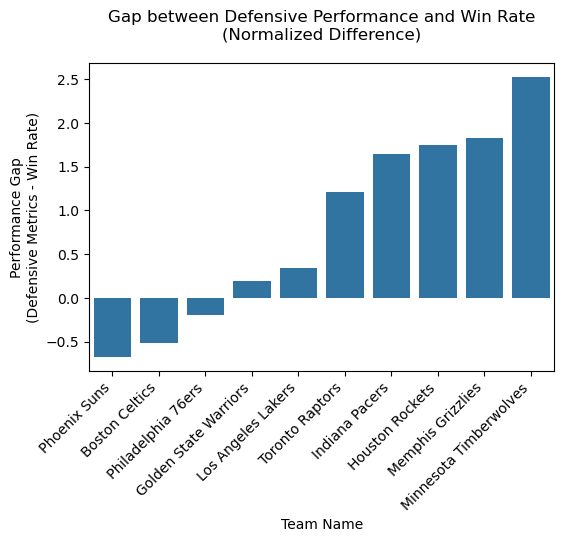

In [109]:
# visualization for falling action 

top10_teams_best_defense = ['Memphis Grizzlies','Toronto Raptors','Minnesota Timberwolves','Philadelphia 76ers',\
                            'Indiana Pacers','Boston Celtics','Los Angeles Lakers','Golden State Warriors','Houston Rockets','Phoenix Suns']

# normalization
normalized_defense = (defense_sorted['combined_blocks_steals'] - defense_sorted['combined_blocks_steals'].mean()) / defense_sorted['combined_blocks_steals'].std()
normalized_winrate = (defense_sorted['win_rate'] - defense_sorted['win_rate'].mean()) / defense_sorted['win_rate'].std()
defense_sorted['performance_gap'] = normalized_defense - normalized_winrate
top10_teams_gap = defense_sorted[defense_sorted['team_name'].isin(top10_teams_best_defense)].sort_values('performance_gap')
plt.figure(figsize=(6, 4))
sns.barplot(data=top10_teams_gap,
           x='team_name',
           y='performance_gap')
plt.title('Gap between Defensive Performance and Win Rate\n(Normalized Difference)', y=1.05)
plt.xlabel('Team Name')
plt.ylabel('Performance Gap\n(Defensive Metrics - Win Rate)')
plt.xticks(rotation=45, ha='right')


#### Resolution

Based on our analysis, we identify three distinct investment categories:

1. Premium Investments (Milwaukee Bucks, Philadelphia 76ers):
 - Balance of defensive capability and winning consistency
 - Proven ability to convert defensive skills into victories
 - Most stable investment prospects
2. Value Opportunities (Denver Nuggets, Boston Celtics):
 - Strong overall performance metrics
 - Effective translation of defensive capabilities into wins
3. Cautionary Investments (Toronto Raptors, Memphis Grizzlies):
 - Superior defensive statistics but lower win rates
 - Need for additional performance factors beyond defense
 - Higher risk profile despite strong defensive metrics

The Milwaukee Bucks and Philadelphia 76ers stand out as particularly attractive investments, demonstrating the crucial balance between defensive capabilities and consistent winning performance.

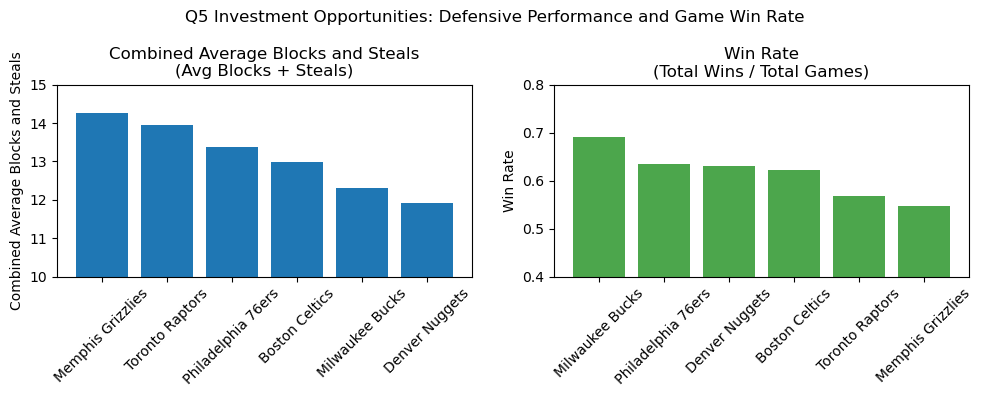

In [110]:
# visualization for resolution

team_of_interest_q5 = ['Milwaukee Bucks', 'Philadelphia 76ers', 'Denver Nuggets', 'Boston Celtics', 'Toronto Raptors', 'Memphis Grizzlies']
team_data_q5 = defense_sorted[defense_sorted['team_name'].isin(team_of_interest_q5)]
defense_sorted_vis = team_data_q5.sort_values('combined_blocks_steals', ascending=False)
winrate_sorted_vis = team_data_q5.sort_values('win_rate', ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# combined avg blocks + steals
ax1.bar(defense_sorted_vis['team_name'], defense_sorted_vis['combined_blocks_steals'])
ax1.set_title('Combined Average Blocks and Steals\n(Avg Blocks + Steals)')
ax1.set_ylabel('Combined Average Blocks and Steals')
ax1.set_ylim(10, 15)

# win rate
ax2.bar(winrate_sorted_vis['team_name'], winrate_sorted_vis['win_rate'], color='green', alpha=0.7)
ax2.set_title('Win Rate\n(Total Wins / Total Games)')
ax2.set_ylabel('Win Rate')
ax2.set_ylim(0.4, 0.8)
plt.sca(ax1)
plt.xticks(rotation=45)
plt.sca(ax2)
plt.xticks(rotation=45)
plt.suptitle('Q5 Investment Opportunities: Defensive Performance and Game Win Rate')
plt.tight_layout()
plt.show()


#### Conclusion

Based on resolutions to our five analytical questions, we have identified three teams that stand out as the best investment opportunities for the upcoming season: 

1. Premium Investment: Boston Celtics
With 75 playoff games over the last five seasons (the highest among all teams) and a win rate of 54.7%, the Boston Celtics demonstrate consistency in playoff success. They maintain a scoring average of 112.83 points per game with a standard deviation of 12.50, indicating strong scoring performance and minimal fluctuations. This makes them a reliable and low-risk investment choice.
  
2. Value Opportunities: Denver Nuggets
The Denver Nuggets have participated in 68 playoff games (the second highest) with a win rate of 54.41%. They also maintain steady scoring at 112.98 points per game, with consistent performance reflected in a scoring standard deviation of 11.77.  Over the past five years, their balanced playoff presence and improving trajectory position them as a strong mid-risk, high-value investment.

3. High Risk/High Return: New York Knicks
Over the last five years, New York Knicks have achieved the greatest scoring improvement (+14.7 points), reflecting their potential for growth. While their win rate remains inconsistent, if the New York Knicks continue their scoring trajectory and address key weaknesses, they could offer significant returns.

In [113]:
con.close

<function Connection.close()>